In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n")

- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [3]:
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

CONFIGURE THE BIGQUERY SETTINGS

In [5]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [6]:
query = """
SELECT 
a.*,
b.average_wage
FROM `ironhacks-data.ironhacks_competition.unemployment_data`a

JOIN `ironhacks-data.ironhacks_competition.wage_data` b 
ON a.uu_id = b.uu_id


"""

In [7]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
#data['timeperiod']= pd.to_datetime(data['timeperiod'])
data.head()

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,0,0,0,11,0,0,<NA>,<NA>,8347.125000
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,<NA>,108,...,35,0,0,0,<NA>,<NA>,0,0,0,7036.636364
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,<NA>,<NA>,...,<NA>,0,0,0,39,0,0,0,0,7890.142857
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,<NA>,<NA>,...,<NA>,0,0,<NA>,10,0,0,<NA>,<NA>,7534.375000
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,<NA>,69,...,65,0,0,0,135,<NA>,<NA>,<NA>,<NA>,11825.125000


In [8]:
data.drop_duplicates(inplace=True)

In [9]:
data = data.fillna(0)

In [10]:
data.describe()

,timeperiod,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
count,13977.0,13977.0,13977.0,13977.0,13977.0,13977.0,13977.0,13977.0,13977.0,13977.0,...,13977.0,13977.0,13977.0,13977.0,13977.0,13977.0,13977.0,13977.0,13977.0,13977.000000
mean,20220478.413322,18.699936,18088.968377,211210.451885,23.049796,0.036131,0.454246,7.025041,3.25542,0.10181,...,4.606854,0.006296,0.010088,0.015025,4.729126,0.121271,0.0,0.23138,6.445518,11656.941853
std,252.868196,11.006898,40.990629,287447.640427,14.68286,0.905556,3.2236,12.074039,8.260031,1.569013,...,10.20408,0.483962,0.466507,0.588166,12.081324,1.991601,0.0,2.334531,10.761054,4135.639055
min,20220101.0,1.0,18001.0,100.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3992.500000
25%,20220226.0,9.0,18063.0,10100.0,14.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8797.600000
50%,20220430.0,18.0,18095.0,42901.0,19.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11044.875000
75%,20220716.0,29.0,18099.0,342600.0,27.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,13895.333333
max,20220910.0,37.0,18183.0,976400.0,170.0,41.0,78.0,137.0,154.0,60.0,...,139.0,49.0,36.0,41.0,163.0,110.0,0.0,74.0,155.0,41267.000000


In [11]:
data.sum(numeric_only=True)

timeperiod             2.826216e+11
week_number            2.613690e+05
countyfips             2.528295e+08
tract                  2.952088e+09
total_claims           3.221670e+05
edu_8th_or_less        5.050000e+02
edu_grades_9_11        6.349000e+03
edu_hs_grad_equiv      9.818900e+04
edu_post_hs            4.550100e+04
edu_unknown            1.423000e+03
gender_female          6.063700e+04
gender_male            6.439000e+04
gender_na              8.800000e+01
race_amerindian        1.410000e+02
race_asian             2.100000e+02
race_black             6.609900e+04
race_noanswer          1.695000e+03
race_hawaiiannative    0.000000e+00
race_other             3.234000e+03
race_white             9.008900e+04
average_wage           1.629291e+08
dtype: float64

In [12]:
data.columns

Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage'],
      dtype='object')

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_14012/3188068582.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


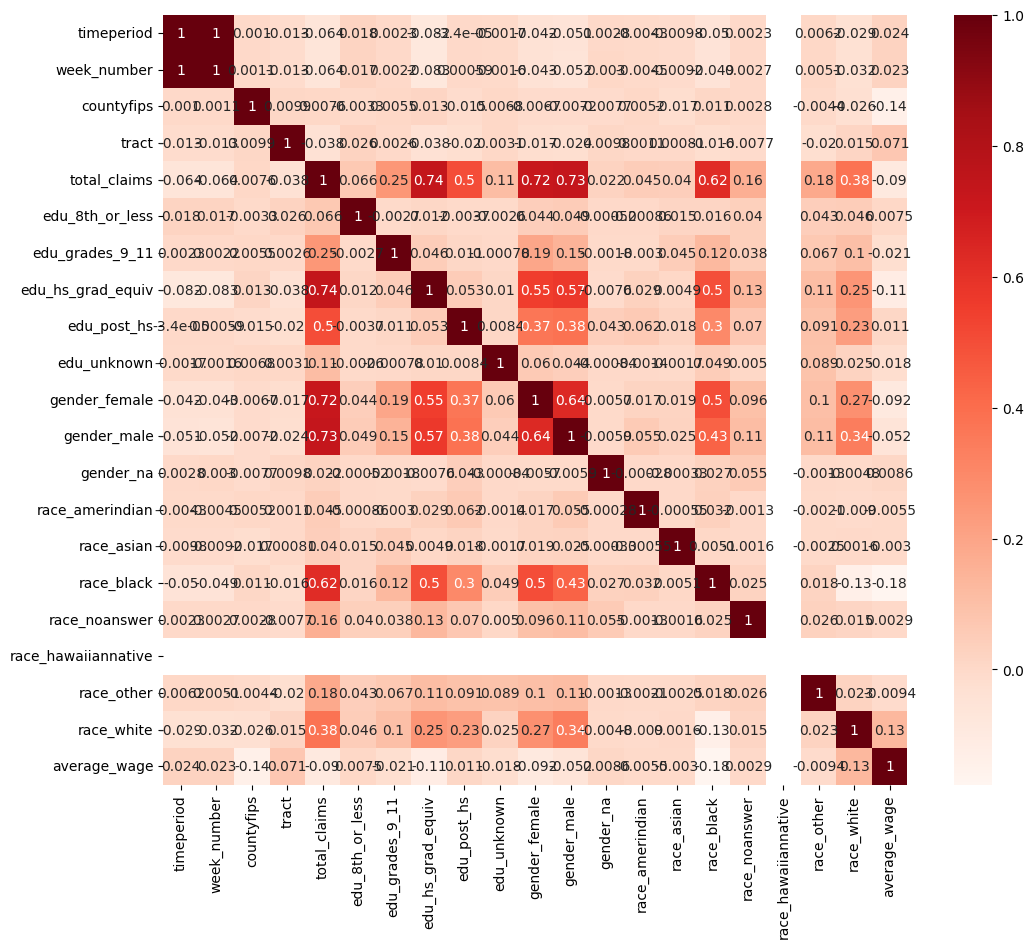

In [13]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [14]:
y = data.total_claims
x = data.drop(['total_claims', 'timeperiod'], axis = 1)

In [15]:
uuid, label = data['uu_id'].factorize(sort=True)

In [16]:
x['uu_id'] = uuid

In [17]:
x['tract_name'] = x['tract_name'].factorize()[0]

In [18]:
x['top_category_employer1'] = x['top_category_employer1'].factorize()[0]
x['top_category_employer2'] = x['top_category_employer2'].factorize()[0]
x['top_category_employer3'] = x['top_category_employer3'].factorize()[0]

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [20]:
x_train

,uu_id,week_number,countyfips,tract,tract_name,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
9157,223,29,18097,310309,347,0,0,13,0,0,...,0,0,0,0,0,0,0,0,0,8141.000000
3418,205,36,18097,310306,486,0,0,25,17,0,...,21,0,0,0,25,0,0,0,0,9311.888889
11821,5,14,18091,41600,36,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,10372.833333
5015,98,24,18097,357600,212,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13,7067.307692
11039,240,9,18141,2400,465,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11163.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15825,501,10,18163,3804,439,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13,13163.083333
3888,397,5,18063,210700,337,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16624.700000
11917,296,19,18039,1501,294,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14126.090909
13040,367,15,18097,361400,215,0,0,13,10,0,...,18,0,0,0,0,0,0,0,18,11044.875000


In [21]:
x_train.columns

Index(['uu_id', 'week_number', 'countyfips', 'tract', 'tract_name',
       'edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv',
       'edu_post_hs', 'edu_unknown', 'top_category_employer1',
       'top_category_employer2', 'top_category_employer3', 'gender_female',
       'gender_male', 'gender_na', 'race_amerindian', 'race_asian',
       'race_black', 'race_noanswer', 'race_hawaiiannative', 'race_other',
       'race_white', 'average_wage'],
      dtype='object')

In [22]:
len(x_train.columns)

24

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(24),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(4)
])

NameError: name 'tf' is not defined

In [24]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

NameError: name 'model' is not defined

In [25]:
model.fit(x_train, y_train, epochs=10)

NameError: name 'model' is not defined

In [26]:
data = data.astype(float)

ValueError: could not convert string to float: 'f013068de98db1470bd986137a0c6d23'

In [27]:
y = data.total_claims
x = data.drop(['total_claims', 'timeperiod'], axis = 1)

In [28]:
uuid, label = data['uu_id'].factorize(sort=True)

In [29]:
x['uu_id'] = uuid

In [30]:
x['tract_name'] = x['tract_name'].factorize()[0]

In [31]:
x['top_category_employer1'] = x['top_category_employer1'].factorize()[0]
x['top_category_employer2'] = x['top_category_employer2'].factorize()[0]
x['top_category_employer3'] = x['top_category_employer3'].factorize()[0]

In [32]:
x = x.astype(float)
y = y.astype(float)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [34]:
len(x_train.columns)

24

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(24),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(4)
])

NameError: name 'tf' is not defined

In [36]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

NameError: name 'model' is not defined

In [37]:
model.fit(x_train, y_train, epochs=10)

NameError: name 'model' is not defined

In [38]:
x['top_category_employer1'].max()

20.0

In [39]:
x.columns

Index(['uu_id', 'week_number', 'countyfips', 'tract', 'tract_name',
       'edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv',
       'edu_post_hs', 'edu_unknown', 'top_category_employer1',
       'top_category_employer2', 'top_category_employer3', 'gender_female',
       'gender_male', 'gender_na', 'race_amerindian', 'race_asian',
       'race_black', 'race_noanswer', 'race_hawaiiannative', 'race_other',
       'race_white', 'average_wage'],
      dtype='object')

In [40]:
for col in x.columns:
    x[col] = x[col]/x[col].max()

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(24),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(4)
])

NameError: name 'tf' is not defined

In [43]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

NameError: name 'model' is not defined

In [44]:
model.fit(x_train, y_train, epochs=10)

NameError: name 'model' is not defined

In [45]:
x_train

,uu_id,week_number,countyfips,tract,tract_name,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
9157,0.425573,0.783784,0.995270,0.317809,0.662214,0.0,0.0,0.094891,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0,0.000000,0.197276
3418,0.391221,0.972973,0.995270,0.317806,0.927481,0.0,0.0,0.182482,0.110390,0.0,...,0.151079,0.0,0.0,0.0,0.153374,0.0,NaN,0.0,0.000000,0.225650
11821,0.009542,0.378378,0.994940,0.042605,0.068702,0.0,0.0,0.080292,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0,0.000000,0.251359
5015,0.187023,0.648649,0.995270,0.366243,0.404580,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0,0.083871,0.171258
11039,0.458015,0.243243,0.997690,0.002458,0.887405,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0,0.000000,0.270520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15825,0.956107,0.270270,0.998900,0.003896,0.837786,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0,0.083871,0.318974
3888,0.757634,0.135135,0.993400,0.215793,0.643130,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0,0.000000,0.402857
11917,0.564885,0.513514,0.992081,0.001537,0.561069,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,0.0,0.000000,0.342310
13040,0.700382,0.405405,0.995270,0.370135,0.410305,0.0,0.0,0.094891,0.064935,0.0,...,0.129496,0.0,0.0,0.0,0.000000,0.0,NaN,0.0,0.116129,0.267644


In [46]:
x_train.fillna(0)

,uu_id,week_number,countyfips,tract,tract_name,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
9157,0.425573,0.783784,0.995270,0.317809,0.662214,0.0,0.0,0.094891,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.197276
3418,0.391221,0.972973,0.995270,0.317806,0.927481,0.0,0.0,0.182482,0.110390,0.0,...,0.151079,0.0,0.0,0.0,0.153374,0.0,0.0,0.0,0.000000,0.225650
11821,0.009542,0.378378,0.994940,0.042605,0.068702,0.0,0.0,0.080292,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.251359
5015,0.187023,0.648649,0.995270,0.366243,0.404580,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.083871,0.171258
11039,0.458015,0.243243,0.997690,0.002458,0.887405,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.270520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15825,0.956107,0.270270,0.998900,0.003896,0.837786,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.083871,0.318974
3888,0.757634,0.135135,0.993400,0.215793,0.643130,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.402857
11917,0.564885,0.513514,0.992081,0.001537,0.561069,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.342310
13040,0.700382,0.405405,0.995270,0.370135,0.410305,0.0,0.0,0.094891,0.064935,0.0,...,0.129496,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.116129,0.267644


In [47]:
model.fit(x_train, y_train, epochs=10)

NameError: name 'model' is not defined